In [1]:
from plot_helpers import *
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats 
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
from scipy.stats import linregress
import matplotlib as mpl


# Set global font sizes - for manuscript
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24
mpl.rcParams['legend.fontsize'] = 18



In [15]:
# Load the statistics CSV file
combined_statistics_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"
df = pd.read_csv(combined_statistics_path)

# other File paths
root_dir = r'C:\Users\Feifei\Box\BR_remote_sensing\ebi_results'


In [16]:
# 2) regroup
df['Group'] = df['Classification'].replace(['HSW','LSW'], 'Wandering')

# 3) styles
markers = {'Wandering':'s','B':'^'}
colors  = {'Wandering':'#FF6666','B':'#4169E1'}

# 4) models
def braided_model(x, A, s):
    return 1 + A * x**(-s)

def wandering_model(x, K, n):
    return 1 + 2.5 / (1 + (x/K)**n)

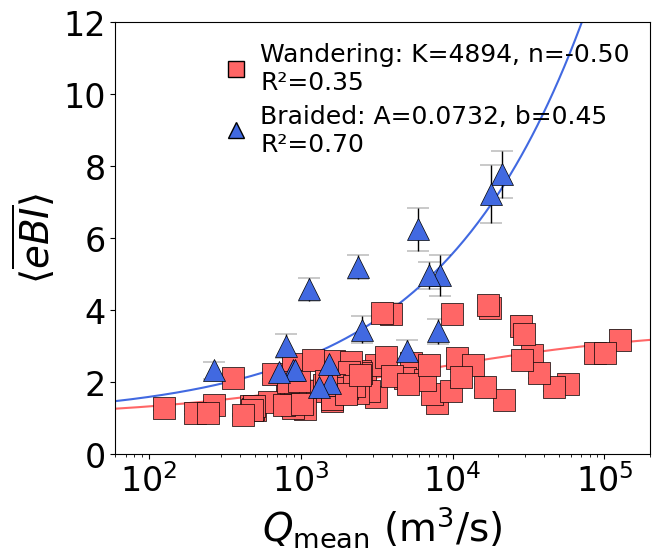

In [17]:
# 1) fixed x_range
x_range = (60, 2e5)
fig, ax = plt.subplots(figsize=(7, 6))
legend_labels = {}

for grp in ['Wandering', 'B']:
    sub  = df[df['Group'] == grp]
    x    = sub['Qm'].values
    y    = sub['mean_ebi_site'].values
    yerr = sub['std_ebi_site'].values / np.sqrt(len(sub))  # display-only SE

    # points + error bars
    ax.errorbar(x, y, yerr=yerr, fmt='none', ecolor='black',
                capsize=8, capthick=0.3, elinewidth=1, zorder=1)
    ax.scatter(x, y, marker=markers[grp], facecolor=colors[grp],
               edgecolor='black', s=250,alpha=1, zorder=2, linewidths=0.5)

    # fit per group
    if grp == 'B':
        popt, _ = curve_fit(braided_model, x, y, p0=[1.0, 0.1], maxfev=2000)
        A_fit, s_fit = popt
        b_fit = -s_fit                     # actual exponent on x
        predict = lambda xx: braided_model(xx, A_fit, s_fit)
        constants = f"Braided: A={A_fit:.3g}, b={b_fit:.2f}"
    else:
        popt, _ = curve_fit(wandering_model, x, y, p0=[np.median(x), 1.0], maxfev=2000)
        K_fit, n_fit = popt
        predict = lambda xx: wandering_model(xx, K_fit, n_fit)
        constants = f"Wandering: K={K_fit:.0f}, n={n_fit:.2f}"

    # R²
    yhat   = predict(x)
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2     = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    # legend label: first line = label+constants, second line = R²
    legend_labels[grp] = f"{constants}\nR²={r2:.2f}"

    # model curve over fixed x_range
    x_line = np.logspace(np.log10(x_range[0]), np.log10(x_range[1]), 300)
    ax.plot(x_line, predict(x_line), color=colors[grp], lw=1.5, zorder=0)

# axes & labels
ax.set_xscale('log')
ax.set_xlim(*x_range)
ax.set_ylim(0, 12)
ax.set_xlabel(r'$Q_{\rm mean}\ (\mathrm{m}^3/\mathrm{s})$')
ax.set_ylabel(r'$\langle\overline{\mathit{eBI}}\rangle$')

# --- legend: markers + two-line labels with group names ---
handles = []
for grp in ['Wandering', 'B']:
    
    handles.append(
        Line2D([0], [0],
               marker=markers[grp], linestyle='None', color='w',
               markerfacecolor=colors[grp], markeredgecolor='black',
               markersize=12, label=legend_labels[grp])
    )

ax.legend(handles=handles, loc='upper right', frameon=False,
          handlelength=1.0, handletextpad=0.5, borderpad=0.3, labelspacing=0.4)

plt.tight_layout()
plt.show()


fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\6_eBI_meanQ.pdf",
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

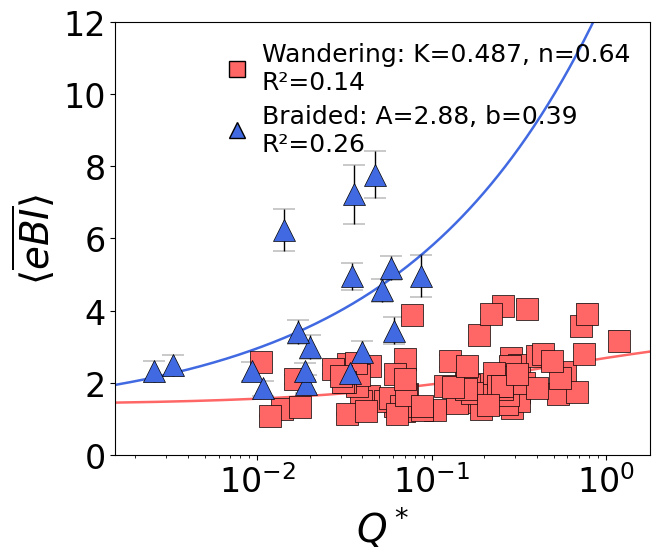

In [27]:
def braided_model(x_scaled, A, b):
    # x_scaled = x / x0  (x0 is a dataset-specific scale)
    return 1 + A * np.power(x_scaled, b)

def wandering_model(x_scaled, K_scaled, n):
    # Hill-style increase from 1.4 -> 3.5 as x increases
    # K_scaled is the half-rise in scaled-x units
    return 1.4 + 2.1 * (np.power(x_scaled, n) / (np.power(x_scaled, n) + np.power(K_scaled, n)))

# ----------------------------
# 4) Prep global x-range & plot
# ----------------------------
x_all = df['dim_Q'].to_numpy()
x_all = x_all[np.isfinite(x_all) & (x_all > 0)]
if x_all.size == 0:
    raise ValueError("No positive, finite dim_Q values found.")

x_range = (np.min(x_all) * 0.6, np.max(x_all) * 1.5)

fig, ax = plt.subplots(figsize=(7, 6))
legend_labels = {}

for grp in ['Wandering', 'B']:
    sub = df[df['Group'] == grp].copy()
    mask = (
        np.isfinite(sub['dim_Q']) &
        np.isfinite(sub['mean_ebi_site']) &
        (sub['dim_Q'] > 0)
    )
    sub = sub[mask]
    if len(sub) < 3:
        continue

    x = sub['dim_Q'].to_numpy()
    y = sub['mean_ebi_site'].to_numpy()
    yerr = (sub['std_ebi_site'].to_numpy() / np.sqrt(len(sub))) if 'std_ebi_site' in sub else None

    # --- scale x to stabilize exponents ---
    x0 = np.median(x)  # scale
    x_scaled = x / x0

    # --- scatter + errorbars ---
    if yerr is not None and np.all(np.isfinite(yerr)):
        ax.errorbar(x, y, yerr=yerr, fmt='none', ecolor='black',
                    capsize=8, capthick=0.3, elinewidth=1, zorder=1)
    ax.scatter(x, y, marker=markers[grp], facecolor=colors[grp],
               edgecolor='black', s=250, alpha=1, zorder=2, linewidths=0.5)

    try:
        if grp == 'B':
            # Initial guesses: A ~ (median(y)-3.5), b ~ 0.6
            A0 = max(0.05, float(np.median(y) - 3.5))
            b0 = 0.6
            # Bounds to avoid flatness: allow big A and b up to 3
            popt, _ = curve_fit(
                braided_model, x_scaled, y,
                p0=[A0, b0],
                bounds=([0.0, 0.0], [50.0, 3.0]),
                maxfev=50000
            )
            A_fit, b_fit = popt
            predict = lambda xx: braided_model(xx / x0, A_fit, b_fit)
            constants = f"Braided: A={A_fit:.3g}, b={b_fit:.2f}"

        else:
            # Wandering: Hill increase 1.4→3.5
            # K0 near the 'mid' x; n0 ~ 1
            K0 = 1.0  # in scaled units (=> K ~ x0 in original units)
            n0 = 1.0
            popt, _ = curve_fit(
                wandering_model, x_scaled, y,
                p0=[K0, n0],
                bounds=([1e-3, 0.1], [100.0, 10.0]),
                maxfev=50000
            )
            K_scaled_fit, n_fit = popt
            predict = lambda xx: wandering_model(xx / x0, K_scaled_fit, n_fit)
            K_fit = K_scaled_fit * x0  # report K in original x units
            constants = f"Wandering: K={K_fit:.3g}, n={n_fit:.2f}"

        # --- R^2 and model curve ---
        yhat   = predict(x)
        ss_res = np.sum((y - yhat)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        r2     = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
        legend_labels[grp] = f"{constants}\nR²={r2:.2f}"

        xx = np.logspace(np.log10(x_range[0]), np.log10(x_range[1]), 300)
        ax.plot(xx, predict(xx), color=colors[grp], lw=1.8, zorder=0)

    except Exception as e:
        legend_labels[grp] = f"{grp}: fit failed\n({e})"

# ----------------------------
# 5) Axes/Legend
# ----------------------------
ax.set_xscale('log')
ax.set_xlim(*x_range)
ax.set_ylim(0, 12)
ax.set_xlabel(r'$Q^*$')
ax.set_ylabel(r'$\langle\overline{\mathit{eBI}}\rangle$')

handles = []
for grp in ['Wandering', 'B']:
    if grp in legend_labels:
        handles.append(
            Line2D([0], [0],
                   marker=markers.get(grp, 'o'), linestyle='None', color='w',
                   markerfacecolor=colors.get(grp, 'gray'), markeredgecolor='black',
                   markersize=12, label=legend_labels[grp])
        )

ax.legend(handles=handles, loc='upper right', frameon=False,
          handlelength=1.0, handletextpad=0.5, borderpad=0.3, labelspacing=0.4)

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\6_eBI_dimQ.pdf",
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)



C:\Users\Feifei\AppData\Local\Temp\ipykernel_37968\2742720778.py:13: RuntimeWarning: invalid value encountered in power
  return 1 + 2.5 / (1 + (x/K)**n)


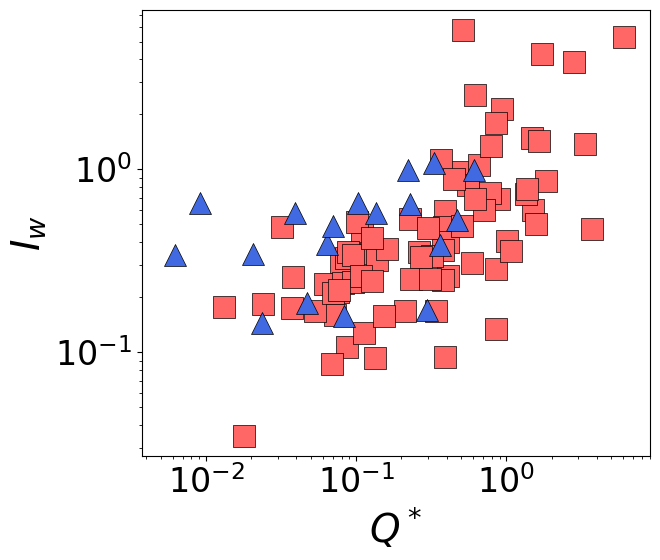

In [12]:
x_range = (df['dim_Q'].min() * 0.6, df['dim_Q'].max() * 1.5)

fig, ax = plt.subplots(figsize=(7, 6))
legend_labels = {}

for grp in ['Wandering', 'B']:
    sub  = df[df['Group'] == grp]
    x    = sub['dim_Q'].values
    y    = sub['Iw'].values

    ax.scatter(x, y, marker=markers[grp], facecolor=colors[grp],
               edgecolor='black', s=250, alpha=1, zorder=2, linewidths=0.5)

    # fit per group
    if grp == 'B':
        popt, _ = curve_fit(braided_model, x, y, p0=[1.0, 0.1], maxfev=2000)
        A_fit, s_fit = popt
        b_fit = -s_fit                     # actual exponent on x
        predict = lambda xx: braided_model(xx, A_fit, s_fit)
        constants = f"Braided: A={A_fit:.3g}, b={b_fit:.2f}"
    else:
        popt, _ = curve_fit(wandering_model, x, y, p0=[np.median(x), 1.0], maxfev=2000)
        K_fit, n_fit = popt
        predict = lambda xx: wandering_model(xx, K_fit, n_fit)
        constants = f"Wandering: K={K_fit:.0f}, n={n_fit:.2f}"

    # R²
    yhat   = predict(x)
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2     = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    # legend label: first line = label+constants, second line = R²
    legend_labels[grp] = f"{constants}\nR²={r2:.2f}"



# axes & labels
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(*x_range)
#ax.set_ylim(0, 12)
ax.set_xlabel(r'$Q^*$') 
ax.set_ylabel(r'${I_{w}}$')

# --- legend: markers + two-line labels with group names ---
handles = []
for grp in ['Wandering', 'B']:
    handles.append(
        Line2D([0], [0],
               marker=markers[grp], linestyle='None', color='w',
               markerfacecolor=colors[grp], markeredgecolor='black',
               markersize=12, label=legend_labels[grp])
    )


plt.tight_layout()
plt.show()


fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\supp_Iw_dimQ.pdf",
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

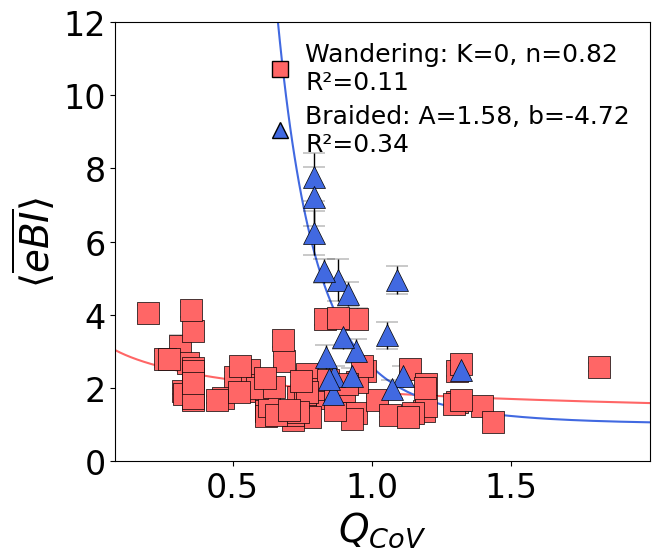

In [53]:
x_range = (df['cov_discharge_site'].min() * 0.4, df['cov_discharge_site'].max() * 1.1)

fig, ax = plt.subplots(figsize=(7, 6))
legend_labels = {}

for grp in ['Wandering', 'B']:
    sub  = df[df['Group'] == grp]
    x    = sub['cov_discharge_site'].values
    y    = sub['mean_ebi_site'].values
    yerr = sub['std_ebi_site'].values / np.sqrt(len(sub))  # display-only SE

    # points + error bars
    ax.errorbar(x, y, yerr=yerr, fmt='none', ecolor='black',
                capsize=8, capthick=0.3, elinewidth=1, zorder=1)
    ax.scatter(x, y, marker=markers[grp], facecolor=colors[grp],
               edgecolor='black', s=250, alpha=1, zorder=2, linewidths=0.5)

    # fit per group
    if grp == 'B':
        popt, _ = curve_fit(braided_model, x, y, p0=[1.0, 0.1], maxfev=2000)
        A_fit, s_fit = popt
        b_fit = -s_fit                     # actual exponent on x
        predict = lambda xx: braided_model(xx, A_fit, s_fit)
        constants = f"Braided: A={A_fit:.3g}, b={b_fit:.2f}"
    else:
        popt, _ = curve_fit(wandering_model, x, y, p0=[np.median(x), 1.0], maxfev=2000)
        K_fit, n_fit = popt
        predict = lambda xx: wandering_model(xx, K_fit, n_fit)
        constants = f"Wandering: K={K_fit:.0f}, n={n_fit:.2f}"

    # R²
    yhat   = predict(x)
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2     = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    # legend label: first line = label+constants, second line = R²
    legend_labels[grp] = f"{constants}\nR²={r2:.2f}"

    # model curve over fixed x_range
    x_line = np.logspace(np.log10(x_range[0]), np.log10(x_range[1]), 300)
    ax.plot(x_line, predict(x_line), color=colors[grp], lw=1.5, zorder=0)

# axes & labels
#ax.set_xscale('log')
ax.set_xlim(*x_range)
ax.set_ylim(0, 12)
ax.set_xlabel(r'${Q_{CoV}}$')
ax.set_ylabel(r'$\langle\overline{\mathit{eBI}}\rangle$')

# --- legend: markers + two-line labels with group names ---
handles = []
for grp in ['Wandering', 'B']:
    handles.append(
        Line2D([0], [0],
               marker=markers[grp], linestyle='None', color='w',
               markerfacecolor=colors[grp], markeredgecolor='black',
               markersize=12, label=legend_labels[grp])
    )

ax.legend(handles=handles, loc='upper right', frameon=False,
          handlelength=1.0, handletextpad=0.5, borderpad=0.3, labelspacing=0.4)

plt.tight_layout()
plt.show()


fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\7_eBI_Qcov.pdf",
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)


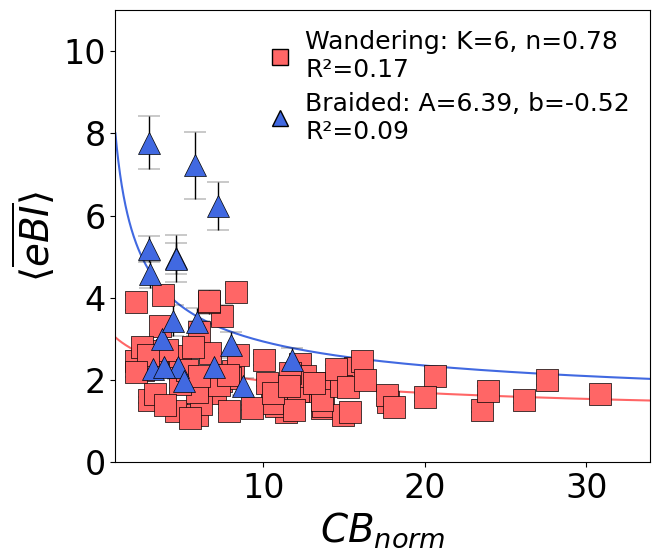

In [57]:
x_range = (df['CB/Aw'].min() * 0.4, df['CB/Aw'].max() * 1.1)

fig, ax = plt.subplots(figsize=(7, 6))
legend_labels = {}

for grp in ['Wandering', 'B']:
    sub  = df[df['Group'] == grp]
    x    = sub['CB/Aw'].values
    y    = sub['mean_ebi_site'].values
    yerr = sub['std_ebi_site'].values / np.sqrt(len(sub))  # display-only SE

    # points + error bars
    ax.errorbar(x, y, yerr=yerr, fmt='none', ecolor='black',
                capsize=8, capthick=0.3, elinewidth=1, zorder=1)
    ax.scatter(x, y, marker=markers[grp], facecolor=colors[grp],
               edgecolor='black', s=250, alpha=1, zorder=2, linewidths=0.5)

    # fit per group
    if grp == 'B':
        popt, _ = curve_fit(braided_model, x, y, p0=[1.0, 0.1], maxfev=2000)
        A_fit, s_fit = popt
        b_fit = -s_fit                     # actual exponent on x
        predict = lambda xx: braided_model(xx, A_fit, s_fit)
        constants = f"Braided: A={A_fit:.3g}, b={b_fit:.2f}"
    else:
        popt, _ = curve_fit(wandering_model, x, y, p0=[np.median(x), 1.0], maxfev=2000)
        K_fit, n_fit = popt
        predict = lambda xx: wandering_model(xx, K_fit, n_fit)
        constants = f"Wandering: K={K_fit:.0f}, n={n_fit:.2f}"

    # R²
    yhat   = predict(x)
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2     = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    # legend label: first line = label+constants, second line = R²
    legend_labels[grp] = f"{constants}\nR²={r2:.2f}"

    # model curve over fixed x_range
    x_line = np.logspace(np.log10(x_range[0]), np.log10(x_range[1]), 300)
    ax.plot(x_line, predict(x_line), color=colors[grp], lw=1.5, zorder=0)

# axes & labels
#ax.set_xscale('log')
ax.set_xlim(*x_range)
ax.set_ylim(0, 11)
ax.set_xlabel(r'${CB_{norm}}$')
ax.set_ylabel(r'$\langle\overline{\mathit{eBI}}\rangle$')

# --- legend: markers + two-line labels with group names ---
handles = []
for grp in ['Wandering', 'B']:
    handles.append(
        Line2D([0], [0],
               marker=markers[grp], linestyle='None', color='w',
               markerfacecolor=colors[grp], markeredgecolor='black',
               markersize=12, label=legend_labels[grp])
    )

ax.legend(handles=handles, loc='upper right', frameon=False,
          handlelength=1.0, handletextpad=0.5, borderpad=0.3, labelspacing=0.4)

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\supp_eBI_CBnorm.pdf",
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)
